In [49]:
##Importar las librerias que se van a usar
import os #Libreria que permite utilizar las dependencias del sistema operativo, como explorador, ver archivos, etc..

import pandas as pd #Libreria que permite trabajar con set de datos
import numpy as np #Libreria matematica para trabajar con vectores y tensores
import matplotlib.pyplot as plt #Libreria para graficar variables
import seaborn as sns #Libreria que trae por defecto graficas como regresión lineal

import tensorflow as tf #Suite tensorflow para aprenziaje profundo de Google
gpus = tf.config.experimental.list_physical_devices('GPU') #Asegura que se tiene GPU para trabajar
tf.config.experimental.set_memory_growth(gpus[0], True) #Asegura que se tiene GPU para trabajar

from tensorflow import keras #Dependencias de tensorflow
from tensorflow.keras import  layers
from sklearn.preprocessing import StandardScaler #Libreria para estandarizar datos

import tensorflow_docs as tfdocs #Dependencias de tensorflow

In [80]:
#First take the first batch of images to tensors in order to use them.
img_train_dir1 = 'D:\Tomografia\All_Project\Images_2'
img_train_dir2 = 'D:\Tomografia\All_Project\Images_1'
train_imgs = []

for img in os.listdir(img_train_dir1):

    img = tf.io.read_file(filename=os.path.join(img_train_dir1,img))
    img = tf.io.decode_image(img, dtype=tf.dtypes.uint8)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0
    for i in range(41):
        train_imgs.append(img[i])

for img in os.listdir(img_train_dir2):

    img = tf.io.read_file(filename=os.path.join(img_train_dir2,img))
    img = tf.io.decode_image(img, dtype=tf.dtypes.uint8)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0
    for i in range(41):
        train_imgs.append(img[i])

train_imgs_np = np.array(train_imgs)
train_imgs_np = np.reshape(train_imgs_np, [-1, 1, 301, 1])

train_imgs_np.shape

(4018, 1, 301, 1)

In [51]:
try_imgs = []
try_img = tf.io.read_file(filename=r'D:\Tomografia\All_Project\Images_2\2.png')
try_img = tf.io.decode_image(try_img, dtype=tf.dtypes.uint8)
try_img = tf.keras.preprocessing.image.img_to_array(try_img)
try_img /= 255.0
for i in range(41):
    try_imgs.append(try_img[i])
try_imgs_np = np.array(try_imgs)
try_imgs_np = np.reshape(try_imgs_np, [-1, 1, 301, 1])

NotFoundError: NewRandomAccessFile failed to Create/Open: D:\Tomografia\All_Project\Images_2\2.png : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]

In [52]:
df = pd.read_csv('D:\Tomografia\All_Project\merged_logs.csv')
df.describe()

,Profundidad,Densidad,PEF,Zeff,Porosidad,Permeabilidad
count,106727.000000,106727.000000,106727.000000,106727.000000,4018.000000,4018.000000
mean,2481.278115,-63.449448,-62.809941,-53.123846,0.128155,1178.282543
std,1863.746803,248.147334,248.320682,250.889891,0.102004,3213.289923
min,674.000000,-999.000000,-999.000000,-999.000000,0.008573,0.002762
25%,750.633243,2.216868,2.029552,12.172757,0.043468,0.068706
50%,807.724491,2.398254,2.661010,13.124068,0.086203,1.016259
75%,4305.348220,2.483573,3.360385,14.002938,0.200881,139.249392
max,4786.018373,5.299557,19.725271,22.894365,0.366091,18157.475410


In [53]:
df.isnull().sum(axis = 0)
df = df.drop(df[df['PEF']<0].index)
df.describe()

,Profundidad,Densidad,PEF,Zeff,Porosidad,Permeabilidad
count,99712.000000,99712.000000,99712.000000,99712.000000,4018.000000,4018.000000
mean,2485.475258,2.368980,3.053478,13.421015,0.128155,1178.282543
std,1868.661274,0.243902,1.427906,1.444801,0.102004,3213.289923
min,674.016404,1.002680,0.375440,7.617576,0.008573,0.002762
25%,751.392450,2.270224,2.141373,12.355462,0.043468,0.068706
50%,807.908013,2.409777,2.737679,13.228029,0.086203,1.016259
75%,4307.523396,2.488105,3.423617,14.075639,0.200881,139.249392
max,4786.008120,5.299557,19.725271,22.894365,0.366091,18157.475410


In [54]:
df = df.dropna()

In [55]:
#Analisis de la informacion
df_numerico = df.drop(['Core', 'Seccion', 'Profundidad'], axis=1)
df_numerico.describe()

,Densidad,PEF,Zeff,Porosidad,Permeabilidad
count,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000
mean,2.397014,3.023744,13.372327,0.128155,1178.282543
std,0.298877,1.437292,1.478697,0.102004,3213.289923
min,1.985576,1.735389,11.654648,0.008573,0.002762
25%,2.268632,2.029940,12.173402,0.043468,0.068706
50%,2.411114,2.632301,13.084582,0.086203,1.016259
75%,2.483558,3.482450,14.142415,0.200881,139.249392
max,5.167703,10.263746,19.094940,0.366091,18157.475410


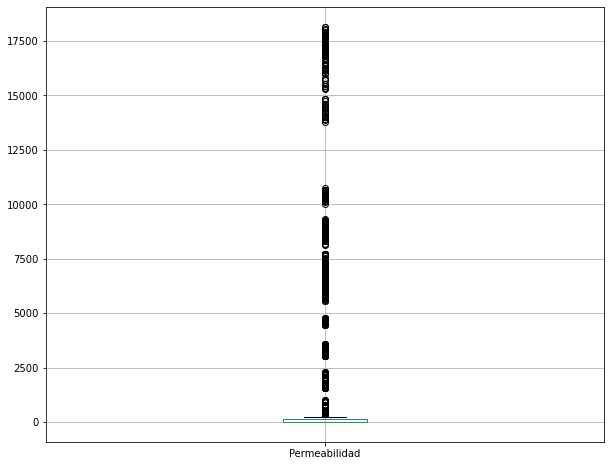

In [56]:
plt.figure(figsize=(10,8))
df.boxplot('Permeabilidad')
plt.show()

In [57]:
porosity_target = df_numerico[['Porosidad']]
numerical_features = df_numerico[['Densidad', 'PEF', 'Zeff']]
imgs_features = train_imgs_np

In [58]:
#Procesar los inputs
standardScaler = StandardScaler()

features_procesados = pd.DataFrame(standardScaler.fit_transform(numerical_features),
                      columns=numerical_features.columns,
                      index= numerical_features.index)
features_procesados.describe()

,Densidad,PEF,Zeff
count,4.018000e+03,4.018000e+03,4.018000e+03
mean,1.556191e-15,9.903035e-17,1.697663e-16
std,1.000124e+00,1.000124e+00,1.000124e+00
min,-1.376783e+00,-8.964881e-01,-1.161761e+00
25%,-4.296025e-01,-6.915282e-01,-8.108991e-01
50%,4.718288e-02,-2.723813e-01,-1.946178e-01
75%,2.895989e-01,3.191856e-01,5.208524e-01
max,9.271474e+00,5.037880e+00,3.870519e+00


In [59]:
from sklearn.model_selection import train_test_split
train_numerical, test_numerical, train_images, test_images, train_target, test_target = train_test_split(features_procesados,
                                                                                                         imgs_features,
                                                                                                         porosity_target,
                                                                                                         test_size=0.2,
                                                                                                         random_state=0)

In [60]:
print('The shape of the training sets are ',
      train_numerical.shape,
      train_images.shape,
      train_target.shape)


The shape of the training sets are  (3214, 3) (3214, 1, 301, 1) (3214, 1)


In [61]:
print('The shape of the test sets are ',
      test_numerical.shape,
      test_images.shape,
      train_target.shape)
train_images[0].shape

The shape of the test sets are  (804, 3) (804, 1, 301, 1) (3214, 1)


(1, 301, 1)

In [62]:
##CNN model for the images
conv_model = tf.keras.models.Sequential([

    layers.Conv2D(16, (3,3), padding='same', activation='relu',
                  input_shape=train_images[0].shape),
    layers.MaxPooling2D(pool_size=(1,2)),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D(32, (3,3),padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(1,2)),
    layers.Conv2D(64, (3,3),padding='same', activation='relu'),
    layers.Dropout(0.2),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='relu')

])

In [63]:
## Regression model for the numerical features
reg_model = tf.keras.models.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(numerical_features.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),

    layers.Dense(16, activation='relu'),
    layers.Dropout(0.15),

    layers.Dense(4, activation='relu')


])

In [64]:
# Combined model
combined_input = layers.concatenate([reg_model.output, conv_model.output])
x = layers.Dense(4, activation='relu')(combined_input)
x = layers.Dense(2, activation='relu')(x)
x = layers.Dense(1)(x)

In [65]:
combined_model = tf.keras.models.Model(inputs=[reg_model.input, conv_model.input],
                                       outputs = x)


In [66]:
combined_model.compile(loss="mse",
                       optimizer=keras.optimizers.Adam(0.001),
                       metrics=['mae','mse'])
combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_6_input (InputLayer)     [(None, 1, 301, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 1, 301, 16)   160         conv2d_6_input[0][0]             
__________________________________________________________________________________________________
dense_36_input (InputLayer)     [(None, 3)]          0                                            
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 1, 150, 16)   0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [67]:
import datetime
keras.utils.plot_model(combined_model, 'combined_model_poro.png', show_shapes=True)

log_dir = "Tensorboard\\poro_logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [68]:
print("[INFO] training model...")
trainig_hist = combined_model.fit(x=[train_numerical, train_images], y=train_target,
	                              validation_split= 0.23,
	                              epochs=300, batch_size=8,
                                  verbose = False,
                                  callbacks=[tensorboard_callback])
print("[INFO] TRAINED FINISHED")

[INFO] training model...
[INFO] TRAINED FINISHED


In [69]:
training_hist_df = pd.DataFrame(trainig_hist.history)

training_hist_df['epoch'] = trainig_hist.epoch

training_hist_df.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,0.000004,0.001492,0.000004,0.000037,0.004058,0.000037,295
296,0.000004,0.001413,0.000004,0.000038,0.004063,0.000038,296
297,0.000004,0.001387,0.000004,0.000035,0.003936,0.000035,297
298,0.000003,0.001262,0.000003,0.000035,0.004108,0.000035,298
299,0.000003,0.001308,0.000003,0.000034,0.003888,0.000034,299


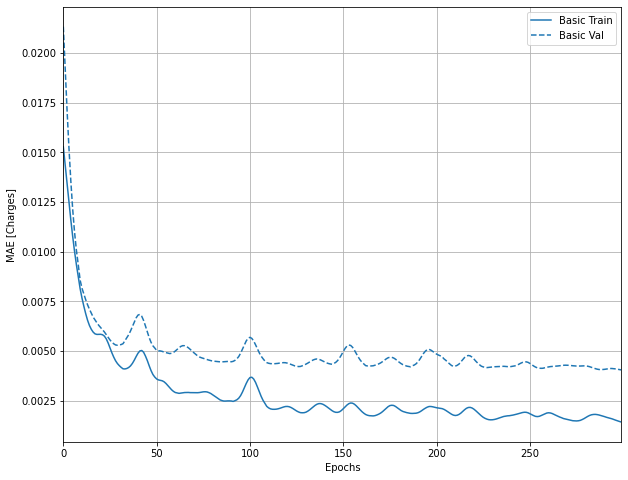

In [70]:
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plt.figure(figsize=(10,8))
plotter.plot({'Basic':trainig_hist}, metric="mae")

plt.ylabel('MAE [Charges]')

plt.show()

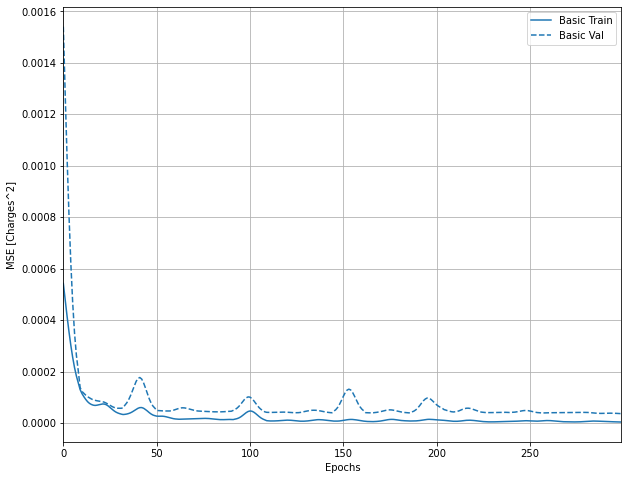

In [71]:
plt.figure(figsize=(10,8))

plotter.plot({'Basic':trainig_hist},metric='mse')
plt.ylabel('MSE [Charges^2]')
plt.show()


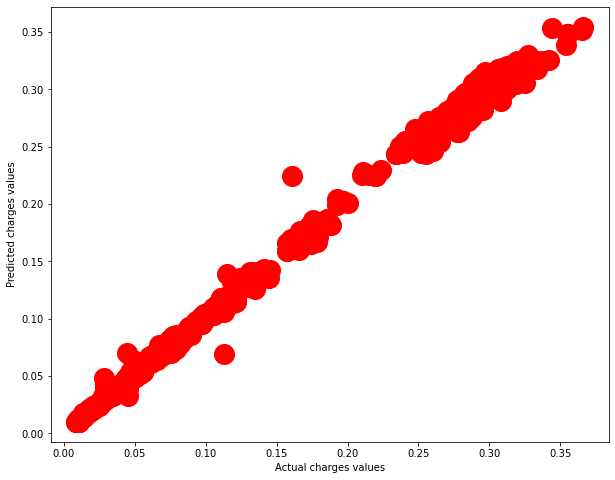

In [72]:
y_pred = combined_model.predict([test_numerical, test_images])

plt.figure(figsize=(10,8))

plt.scatter(test_target, y_pred, s=400, c='red')

plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()

In [73]:
predicted = pd.DataFrame(y_pred)
predicted.head(10)

,0
0,0.029902
1,0.080350
2,0.034610
3,0.280796
4,0.267783
5,0.284386
6,0.296953
7,0.032330
8,0.040978
9,0.317654


In [74]:
target_as_df = pd.DataFrame(test_target)
target_as_df.head(10)

,Porosidad
88683,0.027589
64845,0.074509
89465,0.034422
14232,0.276578
19408,0.259353
33632,0.274199
40670,0.282508
81181,0.034684
96600,0.040574
20074,0.306343


In [75]:
from sklearn.metrics import r2_score
r2_score(test_target, y_pred)


0.9962110750267397

In [76]:
combined_model.save('D:/Tomografia/All_Project/models/real_poro_model9962.h5')

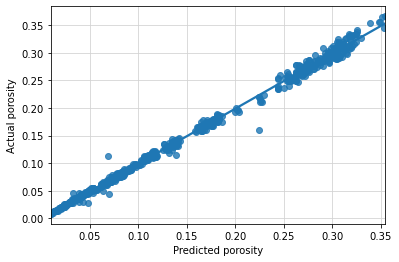

In [82]:
poro_predicted = combined_model.predict([test_numerical,test_images])

actual_porosity = np.array(test_target['Porosidad']).reshape(-1,1)


ax=sns.regplot(x=poro_predicted,y=actual_porosity)
ax.set_xlabel('Predicted porosity')
ax.set_ylabel('Actual porosity')
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray', linestyle='-')
ax.xaxis.grid(color='lightgray', linestyle='-')
ax.get_figure().savefig(r'D:\Tomografia\article\ImagesArticle\porosity.svg')



In [83]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
print('R2_score: {:.4}\nMSE: {:.4}\nMAE: {:.4}\nMax Error: {:.4}'.format(r2_score(actual_porosity, poro_predicted),
                                                               mean_squared_error(actual_porosity,poro_predicted),
                                                               mean_absolute_error(actual_porosity,poro_predicted),
                                                               max_error(actual_porosity, poro_predicted)))


R2_score: 0.9962
MSE: 3.817e-05
MAE: 0.003958
Max Error: 0.06377


In [1]:
##############EVALUATE THE SECTIONS##################
best_poro_model = keras.models.load_model('D:\Tomografia\All_Project\models\poro_model99.h5')

NameError: name 'keras' is not defined

In [22]:
porosity_predicts = best_poro_model.predict([test_numerical, test_images])

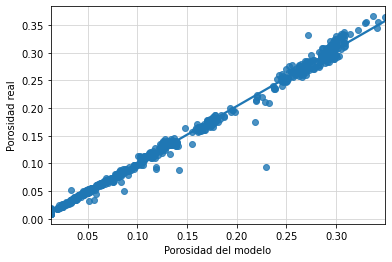

In [24]:
actual_porosity = np.array(test_target['Porosidad']).reshape(-1,1)


ax=sns.regplot(x=porosity_predicts,y=actual_porosity)
ax.set_xlabel('Porosidad del modelo')
ax.set_ylabel('Porosidad real')
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray', linestyle='-')
ax.xaxis.grid(color='lightgray', linestyle='-')
ax.get_figure().savefig('Porosity.png')